In [120]:
import datetime

import psycopg2
import psycopg2.extras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Collection

Needed to gather historical data regarding player, teams, etc.

Fortunately, [ESPN Scrum](espnscrum.com) provides a data on players, teams, and matches going back to 1896.

### Building ```rugby_pg.db```
* Using a scrapy spider built by peloyeje (found [here](https://github.com/peloyeje/map536-rugby-data-scraper)), it was possible to collect a meaningful sample of matches and results, along with player stats for each match to work with.

* After scraping player, team, and match stats from ESPN Scrum the data was inserted into a SQLite database.
    * Although SQLite format is perfectly fine to work with, we have more experience with PostgreSQL. 
    * To make things easier for ourselves, we converted the SQLite into a PostgreSQL database.
  
### Building ```rankings.csv```
* The World Rugby rankings were gathered from [World Rugby's website](https://www.world.rugby/rankings/mru?lang=en) using Beautiful Soup.

* We were able to gather data points containing ```team_name```, ```abbreviation```, ```num_matches```, ```pts```, ```pos```, ```prev_pts```, ```prev_pos```, ```data```.

    * Each data point represents a single team's data from the given date.

    * World Rugby began recording this data on November 2003, so unfortunately there are many years of competition that are not represented in the data set.
    
* The scraping process was done outside of a Jupyter Notebook, due to the heavy memory consumption required to build this large data set

    * Instead, by creating ```csv_writer.py``` and running this python program on a machine with high-spec hardware, the data set ```rankings.csv``` was built.

In [2]:
'''This is the code from csv_writer.py --- it has been commented out to prevent the Jupyter Notebook from building the data set'''


# import json
# import requests
# from bs4 import BeautifulSoup

# from datetime import timedelta, date

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# import csv

# def daterange(start_date, end_date):
#     for n in range(int ((end_date - start_date).days)):
#         yield start_date + timedelta(n)

# start_date = date(2003, 10, 13)
# end_date = date(2019, 11, 15)

# csv_data = [['team_name', 'abbreviation', 'num_matches', 'pts', 'pos', 'prev_pts', 'prev_pos', 'date']]

# for single_date in daterange(start_date, end_date):
#     date = single_date.strftime("%Y-%m-%d")

#     ranking_url = "cmsapi.pulselive.com/rugby/rankings/mru?date=%s&client=pulse" % date
#     r  = requests.get("http://" + ranking_url)

#     soup = BeautifulSoup(r.text)

#     data = json.loads(soup.body.p.text)
#     for entry in data['entries']:
#         csv_data.append(
#             [entry['team']['name'], entry['team']['abbreviation'], 
#              entry['matches'], entry['pts'], entry['pos'], entry['previousPts'], 
#              entry['previousPos'], date]
#         )

# with open('rankings.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     writer.writerows(csv_data)
# csv_file.close()

'This is the code from csv_writer.py --- it has been commented out to prevent the Jupyter Notebook from building the data set'

# Data Visualization -

## Preprocessing ```rankings.csv```

In [3]:
data = pd.read_csv("rankings.csv")

data

,team_name,abbreviation,num_matches,pts,pos,prev_pts,prev_pos,date
0,England,ENG,11,89.948520,1,89.948520,1,2003-10-13
1,New Zealand,NZL,11,89.797710,2,89.797710,2,2003-10-13
2,Australia,AUS,11,84.762690,3,83.805620,4,2003-10-13
3,Ireland,IRE,11,83.924580,4,83.924580,3,2003-10-13
4,France,FRA,11,82.845314,5,82.845314,5,2003-10-13
...,...,...,...,...,...,...,...,...
577110,Monaco,MON,12,23.171558,101,23.171558,101,2019-11-14
577111,Greece,GRE,17,22.546452,102,22.546452,102,2019-11-14
577112,Indonesia,INA,5,21.891422,103,21.891422,103,2019-11-14
577113,Vanuatu,VAN,16,21.453693,104,21.453693,104,2019-11-14


Using Python library ```matplotlib```, we were able to create a few graphs from the ```rankings.csv``` dataset.

We mainly explored the dynamics between the top ranking teams.

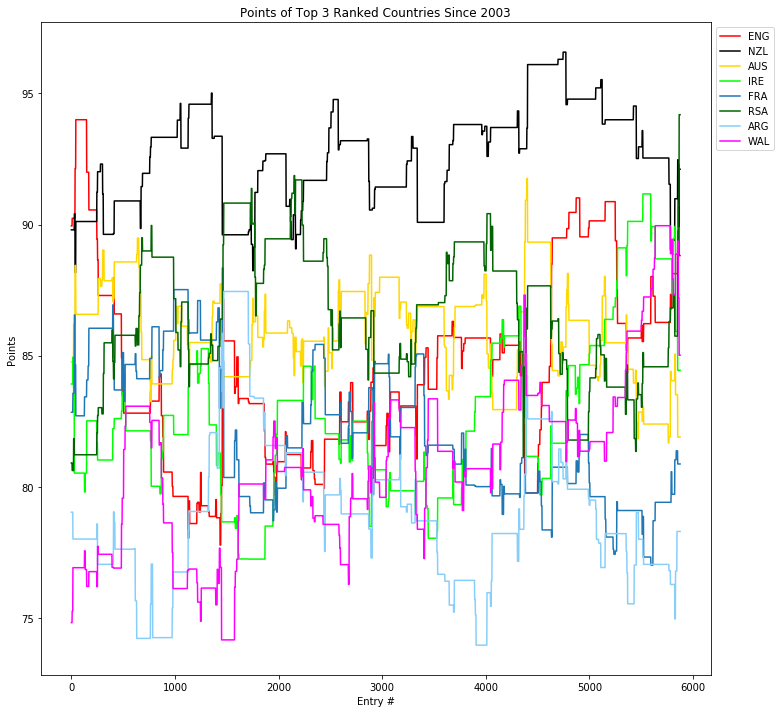

In [4]:
fig = plt.figure(figsize=(12, 12))

for abbr in data.loc[data.pos < 4].abbreviation.unique():
    abbr_pts = data.loc[data.abbreviation == abbr].values[:,[3]]
    if abbr == 'NZL':
        plt.plot(abbr_pts, label = abbr, color = 'black')
    elif abbr == 'ENG':
        plt.plot(abbr_pts, label = abbr, color = 'red')
    elif abbr == 'AUS':
        plt.plot(abbr_pts, label = abbr, color = 'gold')
    elif abbr == 'RSA':
        plt.plot(abbr_pts, label = abbr, color = 'darkgreen')
    elif abbr == 'IRE':
        plt.plot(abbr_pts, label = abbr, color = 'lime')
    elif abbr == 'ARG':
        plt.plot(abbr_pts, label = abbr, color = 'lightskyblue')
    elif abbr == 'WAL':
        plt.plot(abbr_pts, label = abbr, color = 'magenta')
    else:
        plt.plot(abbr_pts, label = abbr)
    
plt.title("Points of Top 3 Ranked Countries Since 2003")
plt.xlabel("Entry #")
plt.ylabel("Points")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

This data is very noisy and does not allow easy understanding of the situation being represented.

- To improve understanding, we will now take the average points per year, rather than the points on each date.

The following table was created directly from 'rankings.csv' by first inserting the file into a postgres server and then using the SQL command:<br />
~~~~sql
    SELECT team_name, pos, extract(year FROM date) AS year, AVG(points)
    FROM rankings
    GROUP BY team_name, pos, year
    HAVING pos < 4
    ORDER BY year;
~~~~

In [5]:
data = pd.read_csv("avg_pts_perteam_perpos_peryr.csv")

data

,team_name,pos,year,avg
0,Australia,2,2003,88.441790
1,Australia,3,2003,86.103692
2,England,1,2003,92.347882
3,England,2,2003,90.238914
4,France,3,2003,86.553150
...,...,...,...,...
119,South Africa,1,2019,94.185720
120,South Africa,2,2019,90.712790
121,Wales,1,2019,89.432526
122,Wales,2,2019,89.782635


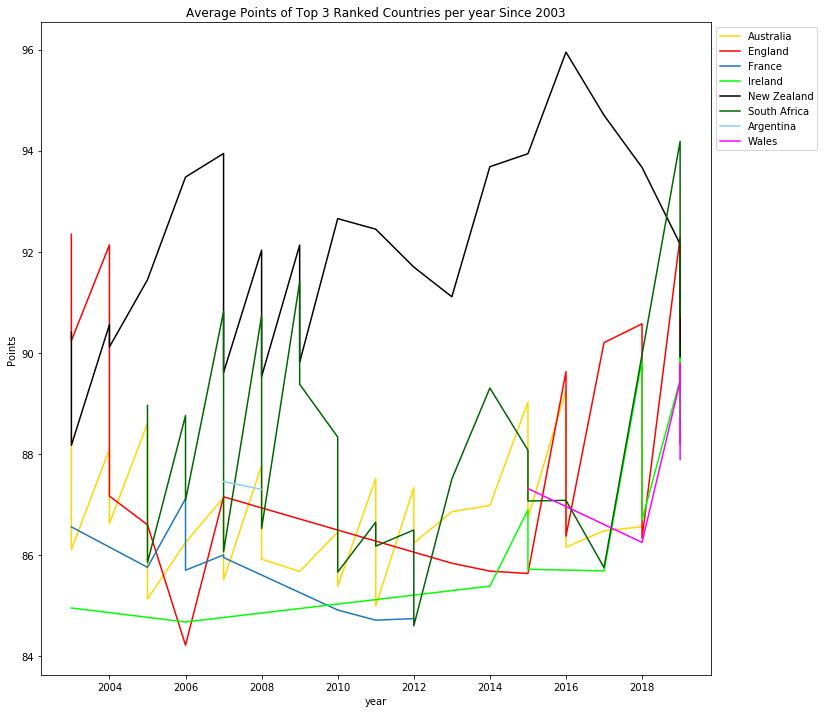

In [6]:
fig = plt.figure(figsize=(12, 12))

for team in data.loc[data.pos < 4].team_name.unique():
    points = data.loc[data.team_name == team].values[:,[3]]
    date = data.loc[data.team_name == team].values[:,[2]]
    if team == 'New Zealand':
        plt.plot(date, points, label = team, color = 'black')
    elif team == 'England':
        plt.plot(date, points, label = team, color = 'red')
    elif team == 'Australia':
        plt.plot(date, points, label = team, color = 'gold')
    elif team == 'South Africa':
        plt.plot(date, points, label = team, color = 'darkgreen')
    elif team == 'Ireland':
        plt.plot(date, points, label = team, color = 'lime')
    elif team == 'Argentina':
        plt.plot(date, points, label = team, color = 'lightskyblue')
    elif team == 'Wales':
        plt.plot(date, points, label = team, color = 'magenta')
    else:
        plt.plot(date, points, label = team)

    
plt.title("Average Points of Top 3 Ranked Countries per year Since 2003")
plt.xlabel("year")
plt.ylabel("Points")
ax = plt.gca()
plt.legend(bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)
plt.show()

We also notice that there are only 8 teams that have only ever been ranked in the top 3 positions, and we verified this by querying the 'rankings.csv' data with:
~~~~sql
SELECT DISTNCT team_name
FROM rankings
WHERE pos < 4;
~~~~

From here, we looked at the average ranking of these teams from 2003 to 2019 to get a better sense of the consistently top ranked teams. The query follows:
~~~~sql
SELECT team_name, AVG(pos) AS average_position
FROM rankings
GROUP BY team_name
HAVING team_name = 'New Zealand'
OR team_name = 'Australia'
OR team_name = 'England'
OR team_name = 'South Africa'
OR team_name = 'France'
OR team_name = 'Ireland'
OR team_name = 'Argentina'
OR team_name = 'Wales'
ORDER BY average_position;
~~~~

In [7]:
data = pd.read_csv("avg_pos.csv")

data

,team_name,average_position
0,New Zealand,1.119789
1,South Africa,3.254722
2,Australia,3.334354
3,England,4.419772
4,Ireland,5.297771
5,France,5.671941
6,Wales,6.401225
7,Argentina,7.638081


We also looked at the worst ranking of these teams from 2003 to 2019 for similar reasons. Again, the query follows:
~~~~sql
SELECT team_name, MAX(pos) AS worst_position
FROM rankings
GROUP BY team_name
HAVING team_name = 'New Zealand'
OR team_name = 'Australia'
OR team_name = 'England'
OR team_name = 'South Africa'
OR team_name = 'France'
OR team_name = 'Ireland'
OR team_name = 'Argentina'
OR team_name = 'Wales'
ORDER BY worst_position;
~~~~

In [8]:
data = pd.read_csv("worst_pos.csv")

data

,team_name,worst_position
0,New Zealand,3
1,South Africa,7
2,Australia,7
3,England,8
4,Ireland,9
5,Wales,10
6,France,10
7,Argentina,12


## Preprocessing ```rugby_pg.db```

In [130]:
conn = psycopg2.connect(dbname="rugby", user="postgres", password="postgres")
cur = conn.cursor(cursor_factory = psycopg2.extras.DictCursor)

cur.execute("SELECT * FROM teams")
data = cur.fetchall()
cur.close()

data

[[1, 'England'],
 [2, 'Scotland'],
 [3, 'Ireland'],
 [4, 'Wales'],
 [5, 'South Africa'],
 [6, 'Australia'],
 [7, 'Germany'],
 [8, 'New Zealand'],
 [9, 'France'],
 [10, 'Argentina'],
 [11, 'United States of America'],
 [12, 'Romania'],
 [13, 'Poland'],
 [14, 'Fiji'],
 [15, 'Samoa'],
 [16, 'Tonga'],
 [17, 'Sri Lanka'],
 [18, 'Spain'],
 [20, 'Italy'],
 [21, 'Belgium'],
 [22, 'Netherlands'],
 [23, 'Japan'],
 [24, 'Morocco'],
 [25, 'Canada'],
 [26, 'Hong Kong'],
 [27, 'Portugal'],
 [28, 'Chile'],
 [29, 'Uruguay'],
 [30, 'Denmark'],
 [31, 'Sweden'],
 [32, 'British and Irish Lions'],
 [33, 'Brazil'],
 [35, 'Kenya'],
 [36, 'Malaysia'],
 [37, 'Tanzania'],
 [38, 'Thailand'],
 [39, 'Uganda'],
 [40, 'Peru'],
 [41, 'Bulgaria'],
 [42, 'Zimbabwe'],
 [43, 'New Caledonia'],
 [45, 'Papua New Guinea'],
 [47, 'Serbia and Montenegro'],
 [48, 'Chinese Taipei'],
 [49, 'Korea'],
 [50, 'Solomon Islands'],
 [51, 'Singapore'],
 [52, 'Madagascar'],
 [53, 'Paraguay'],
 [54, 'Cook Islands'],
 [55, 'Tahiti'],
 [56, 